In [3]:
!pip install tensorflow matplotlib numpy pandas scikit-learn
!pip install git+https://github.com/tensorflow/neural-structured-learning.git

  Cloning https://github.com/tensorflow/neural-structured-learning.git to /tmp/pip-req-build-s2no6k8d
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/neural-structured-learning.git /tmp/pip-req-build-s2no6k8d
  Resolved https://github.com/tensorflow/neural-structured-learning.git to commit 9b5756f8a70af952ba2b86224db3412525e4b447
  Preparing metadata (setup.py) ... done
  Created wheel for neural-structured-learning: filename=neural_structured_learning-1.4.0-py2.py3-none-any.whl size=129776 sha256=dbc2f02bd6d37c77bfb4c274cc16b279d422368abffcb2c0f606550a4c1f27b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-752_scgo/wheels/0d/60/f9/b411311e1133826c206ae6169fb229c3ddd1109454e89a11aa
Successfully built neural-structured-learning


In [4]:
# 6. Verify GPU is available and configured correctly
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# 7. Display GPU info
!nvidia-smi

TensorFlow version: 2.18.0
GPU is available
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Fri Mar  7 07:57:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             48W /  400W |       5MiB /  40960MiB |      0%      Default |
|            

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
from google.colab import files
uploaded = files.upload()

Saving final_dataset.xlsx to final_dataset (1).xlsx


TensorFlow version: 2.18.0
GPU Available:  Yes
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth set to True for all GPUs
Loading and preprocessing pavement data...
Missing values in each column:
STATE_CODE                 0
SHRP_ID                    0
YEAR                       0
CONSTRUCTION_NO            0
MAX_MEAN_DEPTH_1_8         0
ANL_KESAL_LTPP_LN_YR       0
TOTAL_ANN_PRECIP           0
FREEZE_INDEX_YR            0
MAX_ANN_TEMP_AVG           0
MAX_ANN_TEMP_DAYS          0
DAYS_ABOVE_32_C_YR         0
MR_MATL_TYPE               0
RES_MOD_AVG                0
REPR_THICKNESS          5362
dtype: int64
Found 49 outliers in target variable.
Applied winsorization to handle outliers.
Training set: (3541, 10), Validation set: (886, 10), Testing set: (1107, 10)

Identifying important feature interactions...
Feature ranking:
1. TOTAL_ANN_PRECIP (0.3396)
2. ANL_KESAL_LTPP_LN_YR (0.2357)
3. DAYS_ABOVE_32_C_YR (0.1390)
4. FREEZE_INDEX_YR (0.1172)

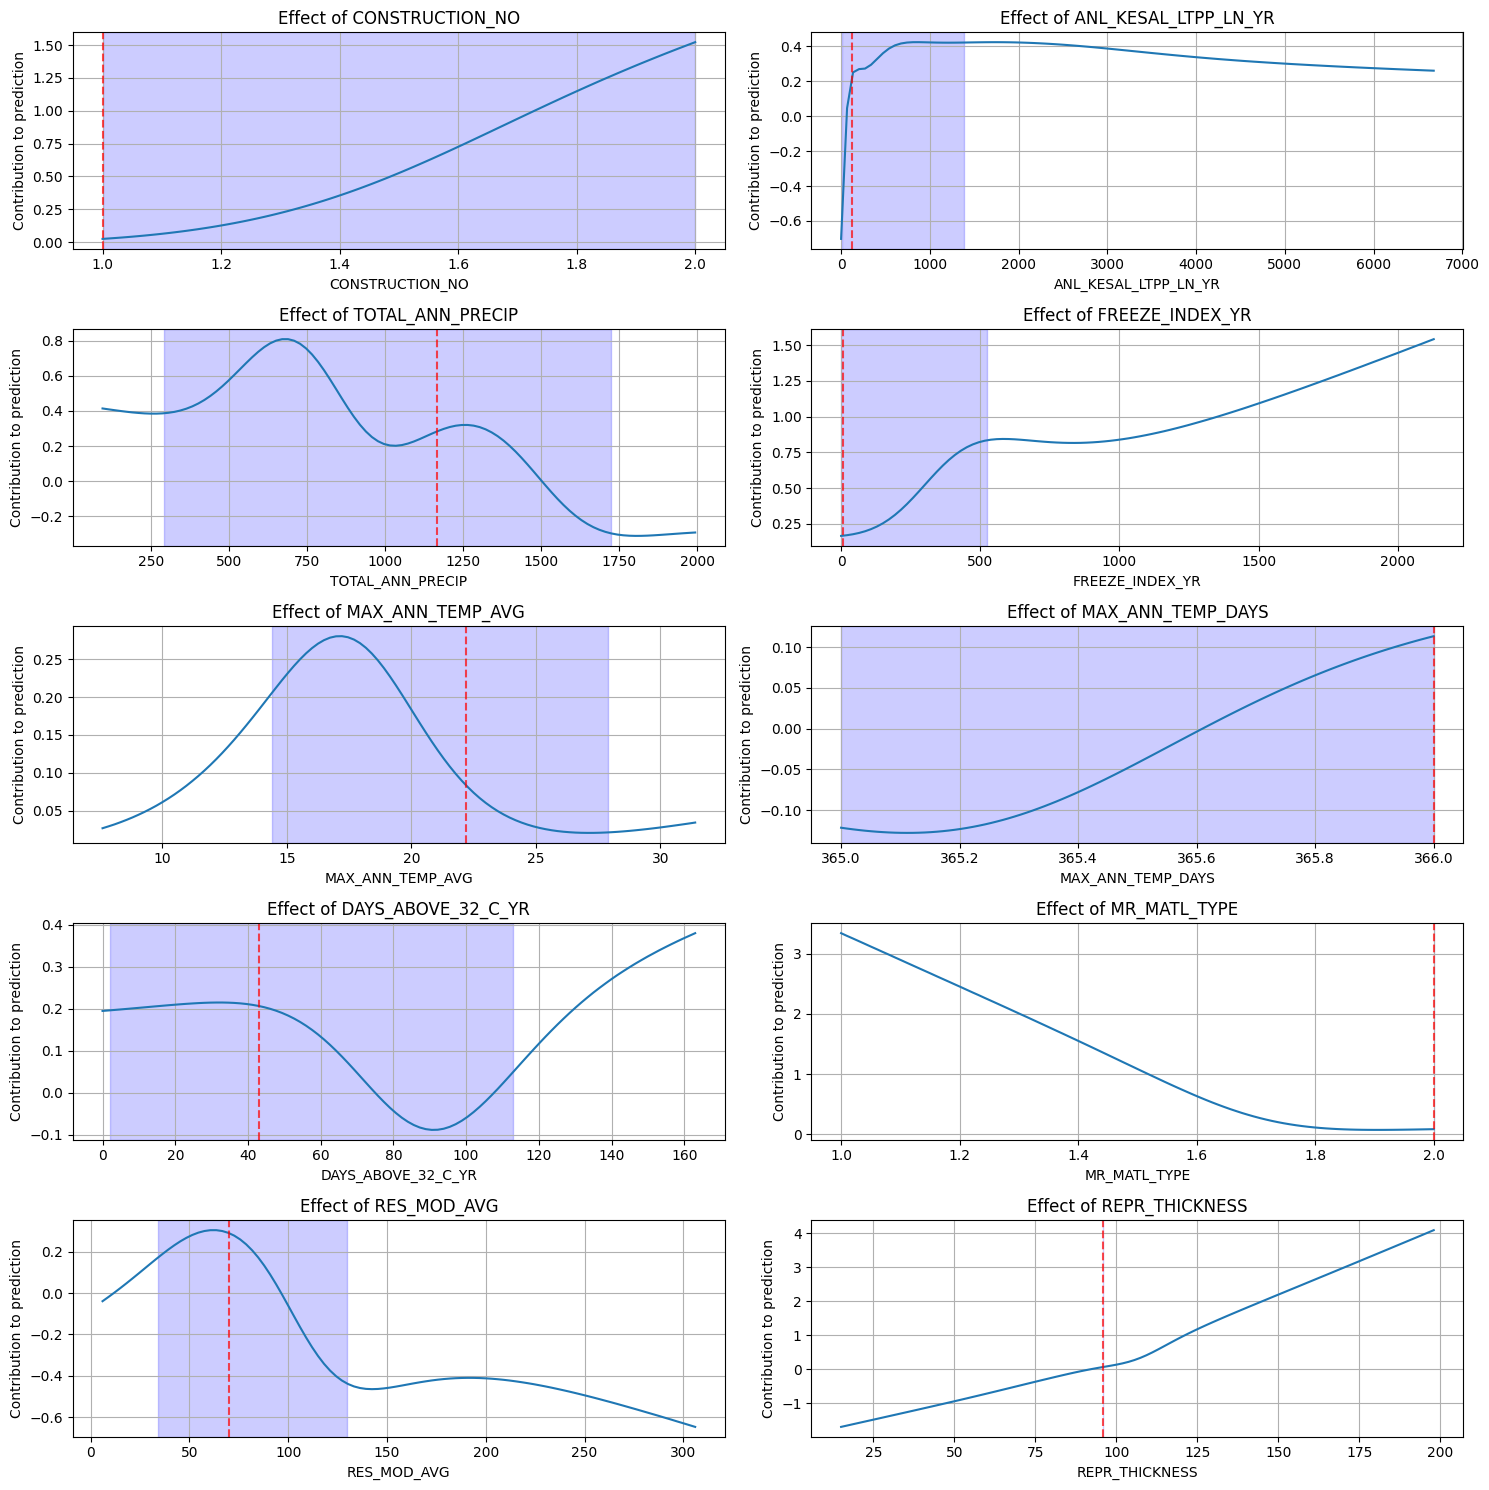


Plotting interaction effects...


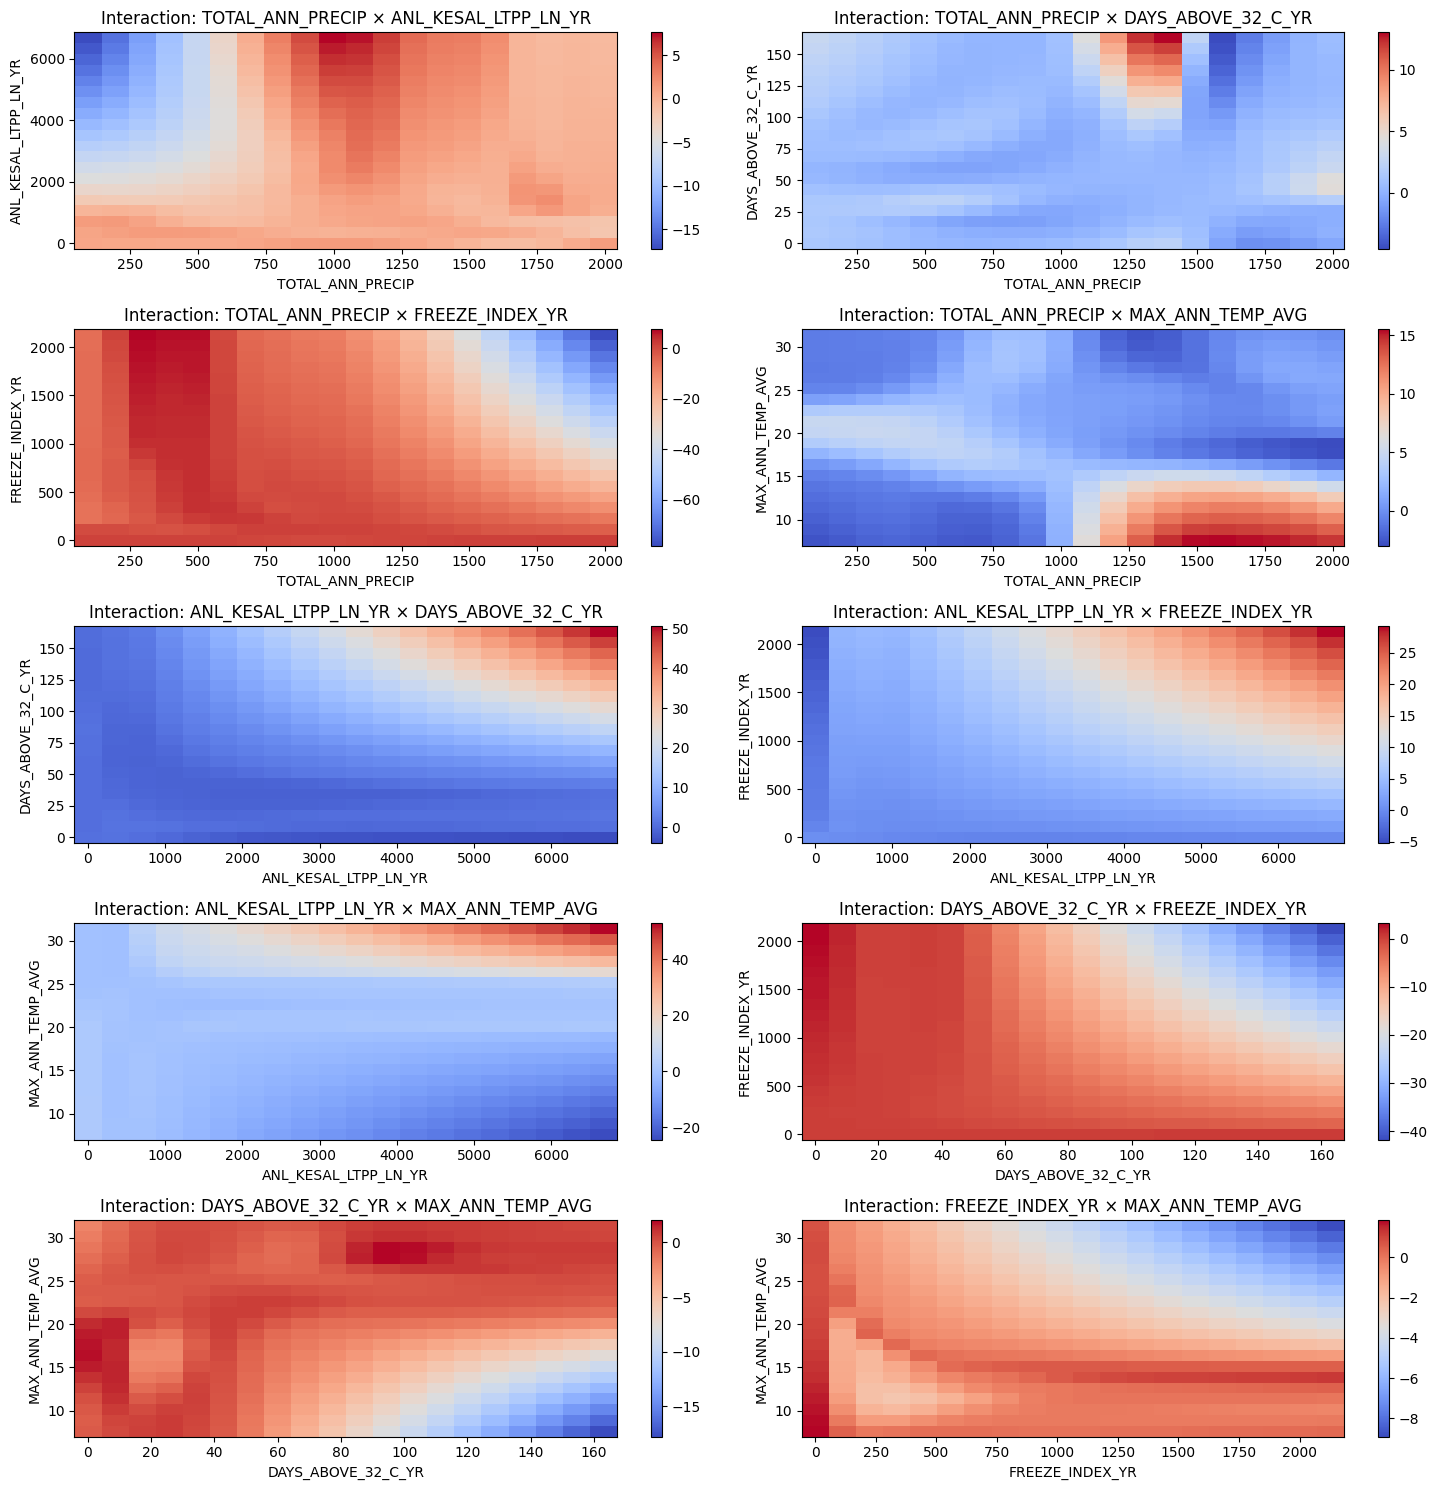

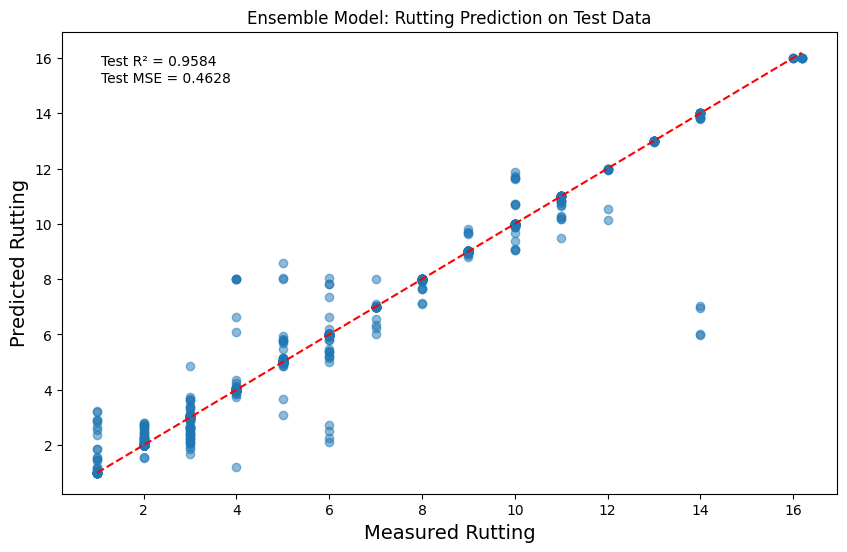

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers, regularizers, callbacks, optimizers
from tensorflow.keras.models import Model, Sequential
import warnings
warnings.filterwarnings('ignore')

# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", "Yes" if tf.config.list_physical_devices('GPU') else "No")
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Enable memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set to True for all GPUs")
    except RuntimeError as e:
        print(e)

# Set global random seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Define the FeatureNet class for NAM architecture with improved flexibility
class FeatureNet(tf.keras.layers.Layer):
    """Single-feature network that learns the shape function for one feature."""

    def __init__(self, hidden_units=[64, 32], activation='relu', regularization=0.01,
                 dropout_rate=0.0, batch_norm=False, name=None):
        super(FeatureNet, self).__init__(name=name)

        # Define the network architecture
        self.hidden_layers = []
        self.dropout_layers = []
        self.batch_norm_layers = []

        for units in hidden_units:
            self.hidden_layers.append(layers.Dense(
                units,
                activation=None,  # We'll apply activation after batch norm if used
                kernel_regularizer=regularizers.l2(regularization),
                kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)
            ))

            if batch_norm:
                self.batch_norm_layers.append(layers.BatchNormalization())
            else:
                self.batch_norm_layers.append(None)

            self.dropout_layers.append(layers.Dropout(dropout_rate, seed=SEED) if dropout_rate > 0 else None)

        # Store activation function
        if activation == 'relu':
            self.activation_fn = tf.nn.relu
        elif activation == 'elu':
            self.activation_fn = tf.nn.elu
        elif activation == 'leaky_relu':
            self.activation_fn = lambda x: tf.nn.leaky_relu(x, alpha=0.2)
        elif activation == 'swish':
            self.activation_fn = tf.nn.swish
        else:
            self.activation_fn = tf.nn.relu

        # Output layer (no activation for regression)
        self.output_layer = layers.Dense(
            1,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)
        )

    def call(self, inputs, training=False):
        x = inputs

        for i, (dense, batch_norm, dropout) in enumerate(
            zip(self.hidden_layers, self.batch_norm_layers, self.dropout_layers)
        ):
            x = dense(x)

            if batch_norm is not None:
                x = batch_norm(x, training=training)

            x = self.activation_fn(x)

            if dropout is not None:
                x = dropout(x, training=training)

        return self.output_layer(x)

# Define the InteractionNet class for capturing pairwise feature interactions
class InteractionNet(tf.keras.layers.Layer):
    """Network for learning pairwise feature interactions."""

    def __init__(self, hidden_units=[32, 16], activation='relu', regularization=0.01,
                 dropout_rate=0.0, batch_norm=False, name=None):
        super(InteractionNet, self).__init__(name=name)

        self.hidden_layers = []
        self.dropout_layers = []
        self.batch_norm_layers = []

        for units in hidden_units:
            self.hidden_layers.append(layers.Dense(
                units,
                activation=None,  # We'll apply activation after batch norm if used
                kernel_regularizer=regularizers.l2(regularization),
                kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)
            ))

            if batch_norm:
                self.batch_norm_layers.append(layers.BatchNormalization())
            else:
                self.batch_norm_layers.append(None)

            self.dropout_layers.append(layers.Dropout(dropout_rate, seed=SEED) if dropout_rate > 0 else None)

        # Store activation function
        if activation == 'relu':
            self.activation_fn = tf.nn.relu
        elif activation == 'elu':
            self.activation_fn = tf.nn.elu
        elif activation == 'leaky_relu':
            self.activation_fn = lambda x: tf.nn.leaky_relu(x, alpha=0.2)
        elif activation == 'swish':
            self.activation_fn = tf.nn.swish
        else:
            self.activation_fn = tf.nn.relu

        self.output_layer = layers.Dense(
            1,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)
        )

    def call(self, inputs, training=False):
        # inputs will be a list of two feature tensors
        feature1, feature2 = inputs

        # Element-wise multiplication to capture interactions
        x = tf.multiply(feature1, feature2)

        # Concatenate with original features to retain information
        x = tf.concat([feature1, feature2, x], axis=1)

        for i, (dense, batch_norm, dropout) in enumerate(
            zip(self.hidden_layers, self.batch_norm_layers, self.dropout_layers)
        ):
            x = dense(x)

            if batch_norm is not None:
                x = batch_norm(x, training=training)

            x = self.activation_fn(x)

            if dropout is not None:
                x = dropout(x, training=training)

        return self.output_layer(x)

# Define the NAM with Interactions model
class EnhancedNAM(tf.keras.Model):
    """Enhanced Neural Additive Model with feature interactions."""

    def __init__(self, feature_nets, interaction_nets=None, interaction_indices=None, num_features=None):
        super(EnhancedNAM, self).__init__()
        self.feature_nets = feature_nets
        self.interaction_nets = interaction_nets or []
        self.interaction_indices = interaction_indices or []
        self.bias = tf.Variable(0., name='bias')
        self.num_features = num_features

    def call(self, inputs, training=False):
        # Reshape inputs to access individual features
        features = tf.split(inputs, self.num_features, axis=1)

        # Get contribution from each feature net
        feature_contributions = []
        for i, feature_net in enumerate(self.feature_nets):
            contribution = feature_net(features[i], training=training)
            feature_contributions.append(contribution)

        # Get contribution from each interaction net
        interaction_contributions = []
        for j, (interaction_net, (idx1, idx2)) in enumerate(zip(self.interaction_nets, self.interaction_indices)):
            contribution = interaction_net([features[idx1], features[idx2]], training=training)
            interaction_contributions.append(contribution)

        # Sum all contributions
        all_contributions = feature_contributions + interaction_contributions
        logits = tf.add_n(all_contributions) + self.bias
        return logits

    def get_feature_contributions(self, inputs, training=False):
        """Get contribution from each feature."""
        features = tf.split(inputs, self.num_features, axis=1)

        contributions = []
        for i, feature_net in enumerate(self.feature_nets):
            contribution = feature_net(features[i], training=training)
            contributions.append(contribution)

        return contributions

    def get_interaction_contributions(self, inputs, training=False):
        """Get contribution from each interaction."""
        if not self.interaction_nets:
            return []

        features = tf.split(inputs, self.num_features, axis=1)

        contributions = []
        for j, (interaction_net, (idx1, idx2)) in enumerate(zip(self.interaction_nets, self.interaction_indices)):
            contribution = interaction_net([features[idx1], features[idx2]], training=training)
            contributions.append(contribution)

        return contributions

# Function to build an enhanced NAM model
def build_enhanced_nam(num_features, hidden_units=[64, 32], activation='relu', regularization=0.01,
                       dropout_rate=0.0, batch_norm=False, interaction_pairs=None):
    """Build an enhanced NAM model with optional interactions."""
    feature_nets = []
    for i in range(num_features):
        feature_nets.append(
            FeatureNet(
                hidden_units=hidden_units,
                activation=activation,
                regularization=regularization,
                dropout_rate=dropout_rate,
                batch_norm=batch_norm,
                name=f'feature_net_{i}'
            )
        )

    interaction_nets = []
    interaction_indices = []

    if interaction_pairs:
        for i, (idx1, idx2) in enumerate(interaction_pairs):
            interaction_nets.append(
                InteractionNet(
                    hidden_units=hidden_units,
                    activation=activation,
                    regularization=regularization,
                    dropout_rate=dropout_rate,
                    batch_norm=batch_norm,
                    name=f'interaction_net_{i}'
                )
            )
            interaction_indices.append((idx1, idx2))

    nam = EnhancedNAM(feature_nets, interaction_nets, interaction_indices, num_features)
    return nam

# Function to generate polynomial features
def generate_polynomial_features(X, degree=2):
    """Generate polynomial features of specified degree."""
    n_samples, n_features = X.shape
    X_poly = np.zeros((n_samples, n_features * degree))

    for d in range(1, degree + 1):
        X_poly[:, (d-1)*n_features:d*n_features] = X ** d

    return X_poly

# Function to train the enhanced NAM model
def train_enhanced_nam(X_train, y_train, X_val, y_val, num_features, feature_names,
                      hidden_units=[64, 32], activation='relu', regularization=0.01,
                      dropout_rate=0.0, batch_norm=False, interaction_pairs=None,
                      epochs=200, batch_size=64, learning_rate=0.001, patience=20,
                      lr_schedule=False, use_warm_up=False):
    """Train an enhanced NAM model with various improvements."""
    # Build model
    model = build_enhanced_nam(
        num_features,
        hidden_units,
        activation,
        regularization,
        dropout_rate,
        batch_norm,
        interaction_pairs
    )

    # Learning rate schedule if needed
    if lr_schedule and not use_warm_up:
        lr = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=1000,
            decay_rate=0.9,
            staircase=True
        )
    elif use_warm_up:
        # Warm-up phase followed by decay
        warmup_steps = 1000
        decay_steps = 5000

        def lr_schedule_fn(step):
            # Linear warmup for warmup_steps steps
            if step < warmup_steps:
                return learning_rate * (step / warmup_steps)
            # Linear decay for decay_steps steps after warmup
            else:
                return learning_rate * (1.0 - ((step - warmup_steps) / decay_steps))

        lr = lr_schedule_fn
    else:
        lr = learning_rate

    # Compile model with appropriate optimizer
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    # Define callbacks
    callback_list = []

    # Early stopping
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    callback_list.append(early_stopping)

    # Learning rate reduction if not using schedule
    if not lr_schedule and not use_warm_up:
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=patience//2,
            min_lr=1e-6,
            verbose=1
        )
        callback_list.append(reduce_lr)

    # Train model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callback_list,
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    return model, history

# Function to detect and handle outliers
def handle_outliers(X, y, method='clip', threshold=3):
    """Detect and handle outliers in the dataset."""
    if method == 'clip':
        # Clip outliers based on z-score
        z_scores = np.abs((y - np.mean(y)) / np.std(y))
        mask = z_scores < threshold
        return X[mask], y[mask]
    elif method == 'winsorize':
        # Winsorize the target variable
        y_mean, y_std = np.mean(y), np.std(y)
        lower_bound = y_mean - threshold * y_std
        upper_bound = y_mean + threshold * y_std
        y_winsorized = np.clip(y, lower_bound, upper_bound)
        return X, y_winsorized
    else:
        # No outlier handling
        return X, y

# Function to perform cross-validation
def cross_validate_nam(X, y, n_splits=5, hidden_units=[64, 32], activation='relu',
                      regularization=0.01, dropout_rate=0.0, batch_norm=False,
                      interaction_pairs=None, epochs=100, batch_size=64,
                      learning_rate=0.001, patience=20, feature_names=None):
    """Perform cross-validation for the NAM model."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    cv_train_r2 = []
    cv_test_r2 = []
    cv_train_mse = []
    cv_test_mse = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{n_splits}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Handle outliers
        X_train, y_train = handle_outliers(X_train, y_train, method='winsorize')

        # Scale features
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train NAM model
        num_features = X_train.shape[1]
        model, _ = train_enhanced_nam(
            X_train_scaled, y_train,
            X_test_scaled, y_test,
            num_features,
            feature_names,
            hidden_units=hidden_units,
            activation=activation,
            regularization=regularization,
            dropout_rate=dropout_rate,
            batch_norm=batch_norm,
            interaction_pairs=interaction_pairs,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            patience=patience
        )

        # Evaluate model
        y_pred_train = model.predict(X_train_scaled).flatten()
        y_pred_test = model.predict(X_test_scaled).flatten()

        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        cv_train_r2.append(train_r2)
        cv_test_r2.append(test_r2)
        cv_train_mse.append(train_mse)
        cv_test_mse.append(test_mse)

        print(f"Fold {fold+1} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
        print(f"Fold {fold+1} - Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

    # Calculate and print average metrics
    avg_train_r2 = np.mean(cv_train_r2)
    avg_test_r2 = np.mean(cv_test_r2)
    avg_train_mse = np.mean(cv_train_mse)
    avg_test_mse = np.mean(cv_test_mse)

    print("\nCross-validation results:")
    print(f"Average Train R²: {avg_train_r2:.4f} ± {np.std(cv_train_r2):.4f}")
    print(f"Average Test R²: {avg_test_r2:.4f} ± {np.std(cv_test_r2):.4f}")
    print(f"Average Train MSE: {avg_train_mse:.4f} ± {np.std(cv_train_mse):.4f}")
    print(f"Average Test MSE: {avg_test_mse:.4f} ± {np.std(cv_test_mse):.4f}")

    return {
        'avg_train_r2': avg_train_r2,
        'avg_test_r2': avg_test_r2,
        'avg_train_mse': avg_train_mse,
        'avg_test_mse': avg_test_mse
    }

# Function to create an ensemble model combining NAM with Random Forest
class EnsembleModel:
    """Ensemble model combining NAM with Random Forest."""

    def __init__(self, nam_model=None, rf_model=None, scaler=None, ensemble_weights=None):
        self.nam_model = nam_model
        self.rf_model = rf_model
        self.scaler = scaler
        self.ensemble_weights = ensemble_weights or [0.5, 0.5]  # Default to equal weighting

    def predict(self, X):
        # Scale features if scaler is provided
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X

        # Get predictions from each model
        nam_preds = self.nam_model.predict(X_scaled).flatten() if self.nam_model else None
        rf_preds = self.rf_model.predict(X) if self.rf_model else None

        # Combine predictions
        if nam_preds is not None and rf_preds is not None:
            return self.ensemble_weights[0] * nam_preds + self.ensemble_weights[1] * rf_preds
        elif nam_preds is not None:
            return nam_preds
        elif rf_preds is not None:
            return rf_preds
        else:
            raise ValueError("No models available for prediction")

# Function to train an ensemble of NAM and RF
def train_ensemble(X_train, y_train, X_val, y_val, feature_names,
                  nam_hidden_units=[64, 32], nam_activation='relu', nam_regularization=0.01,
                  nam_dropout_rate=0.0, nam_batch_norm=False, interaction_pairs=None,
                  nam_epochs=200, nam_batch_size=64, nam_lr=0.001, patience=20,
                  rf_n_estimators=100, rf_max_depth=None, rf_min_samples_split=2,
                  optimize_weights=True):
    """Train an ensemble of NAM and RF models."""
    # Handle outliers
    X_train_clean, y_train_clean = handle_outliers(X_train, y_train, method='winsorize')

    # Scale features for NAM
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_val_scaled = scaler.transform(X_val)

    # Train NAM model
    print("Training NAM model...")
    num_features = X_train.shape[1]
    nam_model, nam_history = train_enhanced_nam(
        X_train_scaled, y_train_clean,
        X_val_scaled, y_val,
        num_features,
        feature_names,
        hidden_units=nam_hidden_units,
        activation=nam_activation,
        regularization=nam_regularization,
        dropout_rate=nam_dropout_rate,
        batch_norm=nam_batch_norm,
        interaction_pairs=interaction_pairs,
        epochs=nam_epochs,
        batch_size=nam_batch_size,
        learning_rate=nam_lr,
        patience=patience
    )

    # Train Random Forest model
    print("\nTraining Random Forest model...")
    rf_model = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        random_state=SEED,
        n_jobs=-1
    )
    rf_model.fit(X_train_clean, y_train_clean)

    # Get predictions from each model
    nam_preds_train = nam_model.predict(X_train_scaled).flatten()
    nam_preds_val = nam_model.predict(X_val_scaled).flatten()
    rf_preds_train = rf_model.predict(X_train_clean)
    rf_preds_val = rf_model.predict(X_val)

    # Determine optimal ensemble weights if requested
    if optimize_weights:
        print("\nOptimizing ensemble weights...")
        best_r2 = -np.inf
        best_weights = [0.5, 0.5]

        for w1 in np.linspace(0, 1, 21):
            w2 = 1 - w1
            ensemble_preds_val = w1 * nam_preds_val + w2 * rf_preds_val
            r2 = r2_score(y_val, ensemble_preds_val)

            if r2 > best_r2:
                best_r2 = r2
                best_weights = [w1, w2]

        print(f"Optimal weights: NAM={best_weights[0]:.2f}, RF={best_weights[1]:.2f}")
        ensemble_weights = best_weights
    else:
        ensemble_weights = [0.5, 0.5]

    # Create and evaluate ensemble model
    ensemble = EnsembleModel(nam_model, rf_model, scaler, ensemble_weights)

    ensemble_preds_train = ensemble.predict(X_train_clean)
    ensemble_preds_val = ensemble.predict(X_val)

    # Calculate metrics
    nam_train_r2 = r2_score(y_train_clean, nam_preds_train)
    nam_val_r2 = r2_score(y_val, nam_preds_val)
    rf_train_r2 = r2_score(y_train_clean, rf_preds_train)
    rf_val_r2 = r2_score(y_val, rf_preds_val)
    ensemble_train_r2 = r2_score(y_train_clean, ensemble_preds_train)
    ensemble_val_r2 = r2_score(y_val, ensemble_preds_val)

    nam_train_mse = mean_squared_error(y_train_clean, nam_preds_train)
    nam_val_mse = mean_squared_error(y_val, nam_preds_val)
    rf_train_mse = mean_squared_error(y_train_clean, rf_preds_train)
    rf_val_mse = mean_squared_error(y_val, rf_preds_val)
    ensemble_train_mse = mean_squared_error(y_train_clean, ensemble_preds_train)
    ensemble_val_mse = mean_squared_error(y_val, ensemble_preds_val)

    print("\nModel Performance:")
    print(f"NAM - Train R²: {nam_train_r2:.4f}, Val R²: {nam_val_r2:.4f}")
    print(f"RF - Train R²: {rf_train_r2:.4f}, Val R²: {rf_val_r2:.4f}")
    print(f"Ensemble - Train R²: {ensemble_train_r2:.4f}, Val R²: {ensemble_val_r2:.4f}")
    print(f"NAM - Train MSE: {nam_train_mse:.4f}, Val MSE: {nam_val_mse:.4f}")
    print(f"RF - Train MSE: {rf_train_mse:.4f}, Val MSE: {rf_val_mse:.4f}")
    print(f"Ensemble - Train MSE: {ensemble_train_mse:.4f}, Val MSE: {ensemble_val_mse:.4f}")

    return {
        'ensemble': ensemble,
        'nam_model': nam_model,
        'rf_model': rf_model,
        'scaler': scaler,
        'ensemble_weights': ensemble_weights,
        'metrics': {
            'nam': {'train_r2': nam_train_r2, 'val_r2': nam_val_r2,
                    'train_mse': nam_train_mse, 'val_mse': nam_val_mse},
            'rf': {'train_r2': rf_train_r2, 'val_r2': rf_val_r2,
                   'train_mse': rf_train_mse, 'val_mse': rf_val_mse},
            'ensemble': {'train_r2': ensemble_train_r2, 'val_r2': ensemble_val_r2,
                         'train_mse': ensemble_train_mse, 'val_mse': ensemble_val_mse}
        }
    }

# Function to identify important feature interactions
def identify_important_interactions(X, y, feature_names, top_n=5):
    """Identify potentially important feature interactions using Random Forest."""
    # Train a Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf.fit(X, y)

    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    for i in range(min(len(feature_names), 10)):
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

    # Get the top n features
    top_features = indices[:min(top_n, len(indices))]

    # Generate pairs of important features for interaction modeling
    interaction_pairs = []
    for i in range(len(top_features)):
        for j in range(i+1, len(top_features)):
            interaction_pairs.append((top_features[i], top_features[j]))

    print("\nSelected feature interactions:")
    for idx1, idx2 in interaction_pairs:
        print(f"{feature_names[idx1]} × {feature_names[idx2]}")

    return interaction_pairs

# Enhanced function to plot feature functions
def plot_feature_functions(model, feature_names, X_scaled, scaler, num_points=100, figsize=(15, 15)):
    """Visualize the contribution of each feature with confidence bands."""

    num_features = len(feature_names)
    rows = (num_features + 1) // 2

    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=figsize)
    axes = axes.flatten()

    # Check if using RobustScaler (has center_ instead of mean_)
    is_robust_scaler = hasattr(scaler, 'center_')

    for i, feature_name in enumerate(feature_names):
        if i >= len(axes):
            break

        # Create a range of points to evaluate the feature function
        feature_min = X_scaled[:, i].min()
        feature_max = X_scaled[:, i].max()
        feature_range = np.linspace(feature_min, feature_max, num_points)

        # Create input data where only the current feature varies
        X_feature = np.zeros((num_points, len(feature_names)))
        X_feature[:, i] = feature_range

        # Get predictions (contributions) from this feature's subnet
        feature_net = model.feature_nets[i]
        contributions = feature_net(X_feature[:, i:i+1]).numpy().flatten()

        # Compute percentiles for the feature to understand data distribution
        pctl_5 = np.percentile(X_scaled[:, i], 5)
        pctl_95 = np.percentile(X_scaled[:, i], 95)

        # Convert scaled values back to original scale for plotting
        if is_robust_scaler:
            # RobustScaler uses center_ (median) instead of mean_
            original_scale = feature_range * scaler.scale_[i] + scaler.center_[i]
            pctl_5_orig = pctl_5 * scaler.scale_[i] + scaler.center_[i]
            pctl_95_orig = pctl_95 * scaler.scale_[i] + scaler.center_[i]
            median_val = np.median(X_scaled[:, i]) * scaler.scale_[i] + scaler.center_[i]
        else:
            # StandardScaler uses mean_
            original_scale = feature_range * scaler.scale_[i] + scaler.mean_[i]
            pctl_5_orig = pctl_5 * scaler.scale_[i] + scaler.mean_[i]
            pctl_95_orig = pctl_95 * scaler.scale_[i] + scaler.mean_[i]
            mean_val = np.mean(X_scaled[:, i]) * scaler.scale_[i] + scaler.mean_[i]

        # Plot the feature function
        axes[i].plot(original_scale, contributions)

        # Shade the 5-95 percentile region to show data distribution
        axes[i].axvspan(pctl_5_orig, pctl_95_orig, alpha=0.2, color='blue')

        # Add vertical lines at mean/median
        if is_robust_scaler:
            axes[i].axvline(x=median_val, color='red', linestyle='--', alpha=0.7, label='Median')
        else:
            axes[i].axvline(x=mean_val, color='red', linestyle='--', alpha=0.7, label='Mean')

        axes[i].set_title(f'Effect of {feature_name}')
        axes[i].set_xlabel(feature_name)
        axes[i].set_ylabel('Contribution to prediction')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    return fig

# Function to plot interaction effects
def plot_interaction_effects(model, interaction_indices, feature_names, X_scaled, scaler, num_points=20, figsize=(15, 15)):
    """Visualize the contribution of feature interactions."""

    if not model.interaction_nets:
        print("No interaction effects to plot.")
        return None

    num_interactions = len(model.interaction_nets)
    rows = (num_interactions + 1) // 2

    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=figsize)
    if rows == 1 and len(model.interaction_nets) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Check if using RobustScaler (has center_ instead of mean_)
    is_robust_scaler = hasattr(scaler, 'center_')

    for k, ((idx1, idx2), interaction_net) in enumerate(zip(model.interaction_indices, model.interaction_nets)):
        if k >= len(axes):
            break

        # Create a grid of points for the two features
        feature1_min = X_scaled[:, idx1].min()
        feature1_max = X_scaled[:, idx1].max()
        feature2_min = X_scaled[:, idx2].min()
        feature2_max = X_scaled[:, idx2].max()

        feature1_range = np.linspace(feature1_min, feature1_max, num_points)
        feature2_range = np.linspace(feature2_min, feature2_max, num_points)

        # Create meshgrid for evaluation
        feature1_grid, feature2_grid = np.meshgrid(feature1_range, feature2_range)

        # Prepare input data
        grid_shape = feature1_grid.shape
        feature1_flat = feature1_grid.flatten()
        feature2_flat = feature2_grid.flatten()

        # Get predictions for interaction
        contributions = interaction_net([
            feature1_flat.reshape(-1, 1),
            feature2_flat.reshape(-1, 1)
        ]).numpy().flatten()

        # Reshape for plotting
        contribution_grid = contributions.reshape(grid_shape)

        # Convert to original scale for axis labels
        if is_robust_scaler:
            # RobustScaler uses center_ (median) instead of mean_
            feature1_orig = feature1_range * scaler.scale_[idx1] + scaler.center_[idx1]
            feature2_orig = feature2_range * scaler.scale_[idx2] + scaler.center_[idx2]
        else:
            # StandardScaler uses mean_
            feature1_orig = feature1_range * scaler.scale_[idx1] + scaler.mean_[idx1]
            feature2_orig = feature2_range * scaler.scale_[idx2] + scaler.mean_[idx2]

        # Plot interaction as heatmap
        im = axes[k].pcolormesh(
            feature1_orig, feature2_orig, contribution_grid,
            cmap='coolwarm', shading='auto'
        )
        fig.colorbar(im, ax=axes[k])

        axes[k].set_title(f'Interaction: {feature_names[idx1]} × {feature_names[idx2]}')
        axes[k].set_xlabel(feature_names[idx1])
        axes[k].set_ylabel(feature_names[idx2])

    # Hide any unused subplots
    for j in range(k+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    return fig

# Main function to run the improved implementation
def run_improved_pavement_nam(data_path='final_dataset.xlsx', use_ensemble=True,
                             use_feature_interactions=True, cross_val=False):
    """Run the complete enhanced NAM analysis on pavement data."""
    print("Loading and preprocessing pavement data...")

    # Load data
    try:
        data = pd.read_excel(data_path)
    except:
        # For Google Colab, may need to upload the file first
        from google.colab import files
        uploaded = files.upload()
        data = pd.read_excel(list(uploaded.keys())[0])

    # Drop any unnamed columns if they exist
    unnamed_cols = [col for col in data.columns if 'Unnamed' in col]
    if unnamed_cols:
        data.drop(unnamed_cols, inplace=True, axis=1)

    # Remove duplicates
    data.drop_duplicates(inplace=True)

    # Check for missing values
    print("Missing values in each column:")
    print(data.isnull().sum())

    # Fill missing values more robustly
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            if data[col].dtype in [np.float64, np.int64]:
                # Use median for numerical columns to be robust to outliers
                data[col].fillna(data[col].median(), inplace=True)
            else:
                # Use mode for categorical columns
                data[col].fillna(data[col].mode()[0], inplace=True)

    # Define features and target
    feature_names = [
        'CONSTRUCTION_NO',
        'ANL_KESAL_LTPP_LN_YR',
        'TOTAL_ANN_PRECIP',
        'FREEZE_INDEX_YR',
        'MAX_ANN_TEMP_AVG',
        'MAX_ANN_TEMP_DAYS',
        'DAYS_ABOVE_32_C_YR',
        'MR_MATL_TYPE',
        'RES_MOD_AVG',
        'REPR_THICKNESS'
    ]

    X = data[feature_names].values
    y = data['MAX_MEAN_DEPTH_1_8'].values

    # Check for and handle outliers in target variable
    z_scores = np.abs((y - np.mean(y)) / np.std(y))
    outliers = z_scores > 3
    if np.sum(outliers) > 0:
        print(f"Found {np.sum(outliers)} outliers in target variable.")
        # Use winsorization rather than removal to retain data
        y_mean, y_std = np.mean(y), np.std(y)
        lower_bound = y_mean - 3 * y_std
        upper_bound = y_mean + 3 * y_std
        y = np.clip(y, lower_bound, upper_bound)
        print("Applied winsorization to handle outliers.")

    if cross_val:
        # Perform cross-validation to get robust performance estimates
        print("\nPerforming 5-fold cross-validation...")
        cv_results = cross_validate_nam(
            X, y, n_splits=5,
            hidden_units=[128, 64, 32],
            activation='swish',
            regularization=0.01,
            dropout_rate=0.2,
            batch_norm=True,
            epochs=300,
            batch_size=64,
            learning_rate=0.001,
            patience=30,
            feature_names=feature_names
        )
        return cv_results

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Further split training data to have a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Testing set: {X_test.shape}")

    # Identify important feature interactions if requested
    interaction_pairs = None
    if use_feature_interactions:
        print("\nIdentifying important feature interactions...")
        interaction_pairs = identify_important_interactions(X_train, y_train, feature_names)

    # Train model (ensemble or single NAM)
    if use_ensemble:
        print("\nTraining ensemble model (NAM + Random Forest)...")
        results = train_ensemble(
            X_train, y_train, X_val, y_val, feature_names,
            nam_hidden_units=[128, 64, 32],
            nam_activation='swish',
            nam_regularization=0.01,
            nam_dropout_rate=0.2,
            nam_batch_norm=True,
            interaction_pairs=interaction_pairs,
            nam_epochs=300,
            nam_batch_size=64,
            nam_lr=0.001,
            patience=30,
            rf_n_estimators=200,
            rf_max_depth=None,
            rf_min_samples_split=2,
            optimize_weights=True
        )

        # Extract models and metrics
        ensemble = results['ensemble']
        nam_model = results['nam_model']
        scaler = results['scaler']
        metrics = results['metrics']

        # Evaluate on test set
        y_pred_test = ensemble.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_r2 = r2_score(y_test, y_pred_test)

        print("\nEnsemble model performance on test set:")
        print(f"Test MSE: {test_mse:.4f}")
        print(f"Test R²: {test_r2:.4f}")

        # Plot feature functions from the NAM component
        print("\nPlotting NAM feature functions...")
        X_train_scaled = scaler.transform(X_train)
        fig_features = plot_feature_functions(nam_model, feature_names, X_train_scaled, scaler)
        plt.show()

        # Plot interaction effects if applicable
        if use_feature_interactions and nam_model.interaction_nets:
            print("\nPlotting interaction effects...")
            fig_interactions = plot_interaction_effects(
                nam_model, nam_model.interaction_indices, feature_names, X_train_scaled, scaler
            )
            plt.show()

        # Plot predicted vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_test, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Measured Rutting', fontsize=14)
        plt.ylabel('Predicted Rutting', fontsize=14)
        plt.title('Ensemble Model: Rutting Prediction on Test Data')
        plt.text(0.05, 0.95, f'Test R² = {test_r2:.4f}\nTest MSE = {test_mse:.4f}',
                 transform=plt.gca().transAxes, verticalalignment='top')
        plt.show()

        # Return models and metrics
        return {
            'ensemble': ensemble,
            'nam_model': nam_model,
            'rf_model': results['rf_model'],
            'scaler': scaler,
            'metrics': {**metrics, 'test': {'mse': test_mse, 'r2': test_r2}}
        }

    else:
        # Just train the enhanced NAM model
        print("\nTraining enhanced NAM model...")

        # Handle outliers in training data
        X_train_clean, y_train_clean = handle_outliers(X_train, y_train, method='winsorize')

        # Scale features
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train_clean)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # Train NAM model with optimized hyperparameters
        num_features = X_train.shape[1]
        model, history = train_enhanced_nam(
            X_train_scaled, y_train_clean,
            X_val_scaled, y_val,
            num_features,
            feature_names,
            hidden_units=[128, 64, 32],
            activation='swish',
            regularization=0.01,
            dropout_rate=0.2,
            batch_norm=True,
            interaction_pairs=interaction_pairs,
            epochs=300,
            batch_size=64,
            learning_rate=0.001,
            patience=30,
            lr_schedule=True
        )

        # Evaluate the model
        y_pred_train = model.predict(X_train_scaled).flatten()
        y_pred_val = model.predict(X_val_scaled).flatten()
        y_pred_test = model.predict(X_test_scaled).flatten()

        # Calculate metrics
        train_mse = mean_squared_error(y_train_clean, y_pred_train)
        val_mse = mean_squared_error(y_val, y_pred_val)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train_clean, y_pred_train)
        val_r2 = r2_score(y_val, y_pred_val)
        test_r2 = r2_score(y_test, y_pred_test)

        print("\nEnhanced NAM Model Performance:")
        print(f"Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
        print(f"Validation MSE: {val_mse:.4f}, R²: {val_r2:.4f}")
        print(f"Testing MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('MAE Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot feature functions
        print("\nGenerating feature function plots...")
        fig = plot_feature_functions(model, feature_names, X_train_scaled, scaler)
        plt.show()

        # Plot interaction effects if applicable
        if use_feature_interactions and model.interaction_nets:
            print("\nPlotting interaction effects...")
            fig_interactions = plot_interaction_effects(
                model, model.interaction_indices, feature_names, X_train_scaled, scaler
            )
            plt.show()

        # Plot predicted vs actual values for test set
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_test, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Measured Rutting', fontsize=14)
        plt.ylabel('Predicted Rutting', fontsize=14)
        plt.title('Enhanced NAM: Rutting Prediction on Test Data')
        plt.text(0.05, 0.95, f'Test R² = {test_r2:.4f}\nTest MSE = {test_mse:.4f}',
                 transform=plt.gca().transAxes, verticalalignment='top')
        plt.show()

        # Return model and metrics
        return {
            'model': model,
            'scaler': scaler,
            'history': history,
            'metrics': {
                'train': {'mse': train_mse, 'r2': train_r2},
                'val': {'mse': val_mse, 'r2': val_r2},
                'test': {'mse': test_mse, 'r2': test_r2}
            }
        }

# Run the improved implementation
if __name__ == "__main__":
    # Set to True to use ensemble model, False to use only enhanced NAM
    USE_ENSEMBLE = True

    # Set to True to model feature interactions, False for standard NAM
    USE_INTERACTIONS = True

    # Set to True to perform cross-validation, False for single train/test split
    CROSS_VALIDATE = False

    results = run_improved_pavement_nam(
        use_ensemble=USE_ENSEMBLE,
        use_feature_interactions=USE_INTERACTIONS,
        cross_val=CROSS_VALIDATE
    )